# EXTRA: output playground

Here's a fun little janky treat that I threw together mostly for fun, but I think there are intuitions that can be gained from it.

This is a stable diffusion playground that connects to your google drive, and lets you save your stable diffusion outputs as gifs! If you run this script and give it access to your google drive, it'll let you save an animated gif of your noisy output and denoised output slowly turning into a final image, as well as your inputs to generate your specific outputs. These will all go into separate folders in an SD_outputs/ folder in your google drive.

The easiest way to run this is to hit 'Runtime'>'Run all' or Ctrl+F9, which will automatically run everything, and then save our default output (An astronaut on a horse) into your google drive. Then, you can iterate in section 2, where it says, in big bold letters, 'ITERATE HERE'.

Another note, you should probably run this on a GPU instance of colab, which you can select in the top-right corner of the colab UI, with a little drop down arrow. It *should* still work on a CPU instance, but it'll be much much slower. You can also run this locally, you'll just have to remove the google drive mounting code, and change the directory variables accordingly.

Happy generating!

In [6]:
!pip install diffusers

Defaulting to user installation because normal site-packages is not writeable


In [11]:
from PIL import Image
from tqdm.auto import tqdm
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from torchvision import transforms

import json

torch_device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

#4. the schedule algorithm used to "renoise" the image
scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

# moving to GPU and halving precision for inference speed.
vae = vae.to(torch_device).half()
text_encoder = text_encoder.to(torch_device).half()
unet = unet.to(torch_device).half()

# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os

if not os.path.isdir('/content/drive/MyDrive/SD_outputs'):
  os.makedirs('/content/drive/MyDrive/SD_outputs')

output_dir='/content/drive/MyDrive/SD_outputs/'

#define embedding generation function for downstream use - this
def text_embedder(texts_list):
    text_input = tokenizer(texts_list, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

    text_embeddings=text_embeddings.sum(dim=0).reshape([1,77,768])
    text_embeddings=text_embeddings/len(texts_list)
    return text_embeddings

#define image import function, for downstream use
def injection_image2latent(image_str):
    injection=Image.open(image_str)
    injection=injection.resize((64,64))
    injection=injection.convert("RGBA")
    transform = transforms.Compose([
    transforms.PILToTensor()
        ])

    injectLatent=transform(injection).numpy()
    injectLatent=injectLatent.astype("float16")/255
    injectLatent=torch.Tensor(injectLatent).half()
    injectLatent=injectLatent.reshape([1,4,64,64]).to(torch_device)

    with torch.no_grad():
        noise_pred = unet(injectLatent, scheduler.init_noise_sigma, encoder_hidden_states=uncond_embeddings).sample

    latents = scheduler.step(noise_pred, scheduler.init_noise_sigma, injectLatent).prev_sample

    return latents


def latents2img(latents):
    latents = 1 / 0.18215 * latents
    latents = latents.half()
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    # print(images.shape)
    pil_images = [Image.fromarray(image) for image in images]

    pil_images[0]
    return pil_images[0]

#function for image generation
def StableDiffusion(uncond_input, text_input, height, width, num_inference_steps, guidance_scale, seed, image):
    text_embeddings=text_embedder(text_input)
    uncond_embeddings=text_embedder(uncond_input)


    batch_size=1

    generator=torch.manual_seed(seed)

    if not image:
        latents = torch.randn(
            (batch_size, unet.config.in_channels, height // 8, width // 8),
            generator=generator,
            )
    else:
        latents = injection_image2latent(image)

    latents = latents.to(torch_device)

    latents = latents * scheduler.init_noise_sigma

    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    scheduler.set_timesteps(num_inference_steps)

    noisy_outputs_list=[]
    clean_outputs_list=[]
    for t in tqdm(scheduler.timesteps):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)

        latent_model_input = scheduler.scale_model_input(latent_model_input, t).half()

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        all_latents = scheduler.step(noise_pred, t, latents)
        clean_latents = all_latents.pred_original_sample
        latents = all_latents.prev_sample
        #save intermediate decoded outputs, for viewing pleasure
        noisy_outputs_list.append(latents2img(latents))
        clean_outputs_list.append(latents2img(clean_latents))

    input_dict={
        'uncond_input': uncond_input,
        'text_input': text_input,
        'height': height,
        'width': width,
        'num_inference_steps': num_inference_steps,
        'guidance_scale': guidance_scale,
        'seed': seed,
        'image': image
    }
    return (noisy_outputs_list, clean_outputs_list, input_dict)

def save_outputs(output, dir):
    name = '--'.join(output[2]['text_input'])+'_'+str(output[2]['seed'])
    savedir=dir + name + '/'
    if not os.path.isdir(savedir):
      os.mkdir(savedir)
    output[0][0].save(savedir + 'noisy_output.gif',
               save_all=True, append_images=output[0][1:], optimize=False, duration=1, loop=0)
    output[1][0].save(savedir + 'clean_output.gif',
            save_all=True, append_images=output[1][1:], optimize=False, duration=1, loop=0)
    with open(savedir+"inputs.json", "w") as writefile:
      json.dump(output[2], writefile)


# ITERATE HERE

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.68it/s]


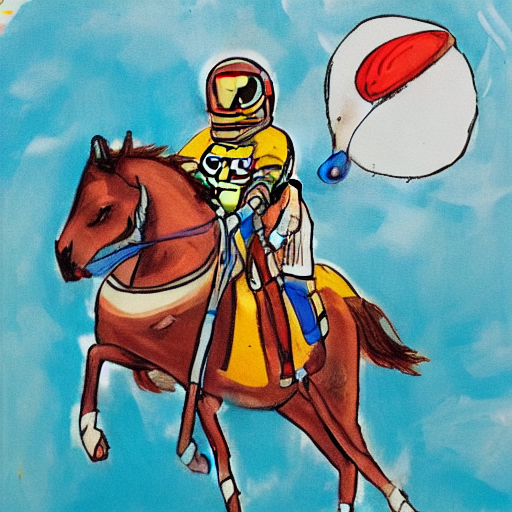

In [12]:
output=StableDiffusion(
    text_input=['Astronaut on a horse'],
    uncond_input=[''],
    height=512,
    width=512,
    num_inference_steps=10,
    guidance_scale=7.5,
    seed=42,
    image=False)

output[1][-1]

In [ ]:
#if you like it - save the outputs here. NOTE: YOUR OUTPUTS WILL OVERWRITE IF YOU HAVEN'T CHANGED THE TEXT_INPUT AND/OR SEED VARIABLES.
save_outputs(output, output_dir)

In [ ]:
[]